Importing the modules os and pandas and the classes ML_GRB and RND_FOREST from the ML_GRB.py file.
I will use "os" to take the path of the working folder for the data reading part, while "pandas" to manage the DataFrame.

The class ML_GRB is the main class of the project, while RND_FOREST is the class for the specific model to use in the main class "ML_GRB". The idea is to create other model classes like "RND_FOREST" using similiar structure betwen the model class and the main class (see "ML_GRB.py" for more details).

In [1]:
import os
import pandas as pd
from ML_GRB import ML_GRB, RND_FOREST

Now I intitialize the main class and save it in the variable "obj". Then I use the function 
DataReading (see functions.py) to read the data from the folder "data". This function takes in 
input the working folder path and saves the data as istances in the class

In [2]:
# dir_path = os.path.dirname(os.path.abspath(__file__))   # directory path (This doesn't 
#                                                           work in python notebook, but it
#                                                           works very well in python files, 
#                                                           so here I use the line below, and
#                                                           one can change it if necessary.)
dir_path = ''       # directory path

obj = ML_GRB()      # initializing the main class ---> see ML_GRB.py
obj.DataReading(dir_path)       # reading the data ---> see functions.py

Here I build the dataset to work with.
First I take the DataFrames of spectral and energetic parameters and I save they in two variables.
Then I take just the features useful for the model (for now I take the features below for a test but the code should works fine even with all the necessary variables of the dataset).
After that I concatenate the two DataFrame to a single DataFrame tha will works as our 
dataset for the model.
Here I choose to take only the data fitted with the CPL model just for a test, but honestly 
the implication of this are a bit confusing for me. This could be one of the theme for a possible 
next meeting.

Finally one can filter the dataset again changing the features list.
I've done this because in my mind the first filter is useful to select the features usable in general, 
while the last filter is to select the specific features to use in the model.

In [3]:
# Taking the dataframes from the class
spec_par = obj.spectral_data
energ_par = obj.energetic_data

# Defining the features to use in the model from the two dataframes
filter_ener = ['z', 'S', 'Tp64', 'Fp64', 'Eiso','Liso']
filter_spec = ['tstart', 'DeltaT', 'alpha', 'Ep', 'F']

spec_par_reset = spec_par.reset_index(drop=True)  # Reset index and drop the old index column

# Concatenating the two dataframe to form one and filtering
df1 = energ_par[energ_par['ID'] != 'GRB080413B'][filter_ener]   # Exluding GRB080413B becuase 'SMOD' = 'PL'
df2 = spec_par_reset[(spec_par['SMod'] == 'CPL') & (spec_par['SType'] == 'i')][filter_spec]    # Using the CPL SMod
df_temp = pd.concat([df1, df2], axis=0)     # Concatenating
df = df_temp.apply(lambda x: pd.Series(x.dropna().values))      # Dropping the Nan values

# Selecting the features to use (one can change directly from here if he wants)
features = ['z', 'S', 'Tp64', 'Fp64', 'Eiso','Liso', 
          'tstart', 'DeltaT', 'alpha', 'Ep', 'F']
dataset = df[features]

Here I write a simple implementation of the function CorrMatrix to draw a correlation matrix
and to save it in the images folder.

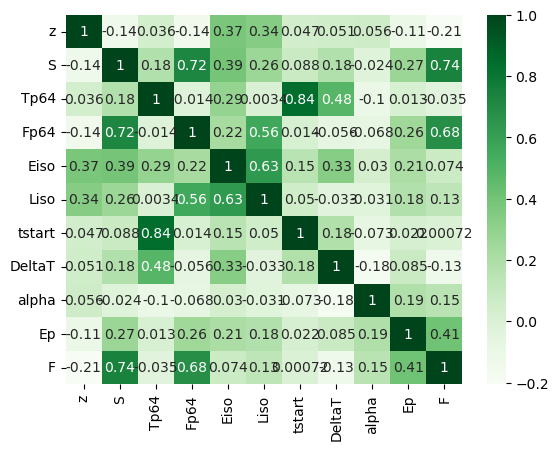

In [4]:
import matplotlib.pyplot as plt

obj.CorrMatrix(dataset)
plt.savefig(dir_path + 'images/img_name.png')

In the next cell I initialize the model class and save it in the variable "model", then 
I set the model in the main class (see ML_GRB.py). 
After that I train the model with the function Run (see functions.py).

I had set a random_state of 42 to split training and testing data in the same way every time 
I run the code, just to hate always the same results in this first "code testing" moment.

In [5]:
# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
obj.SetModel(model)     # Setting the model in the main class

# Fitting the model ---> see functions.py
obj.model.Run(dataset, train_size = 0.66, random_state = 42,
              n_estimators = 500, max_depth = 20)

In the last cell I print the results: 
- the values of redshift from the test data compared with the values of redshift predicted by the model
- the score on the test data
- the score on the train data

In the next future I want to implement some consinstent tools to evaluate the model.
For now I have printed only simple results that doesn't has much estimation values, just
to test the code.

In [6]:
# Printing the results
test_score = obj.model.forest.score(obj.model.X_test, obj.model.y_test)
train_score = obj.model.forest.score(obj.model.X_train, obj.model.y_train)

for a, b in zip(obj.model.y_test, obj.model.y_pred):
    print('z test: {:1.3f}\t\tz predicted: {:1.3f}'.format(a, b))
    
print('The test score is : {:.3f} while the train score is: {:.3f}'.format(test_score, train_score))

z test: 2.770		z predicted: 2.887
z test: 0.360		z predicted: 0.366
z test: 0.360		z predicted: 0.367
z test: 0.540		z predicted: 0.532
z test: 3.600		z predicted: 3.731
z test: 2.770		z predicted: 2.793
z test: 2.690		z predicted: 2.671
z test: 0.760		z predicted: 0.722
z test: 4.350		z predicted: 3.978
z test: 3.000		z predicted: 3.127
z test: 1.410		z predicted: 1.417
z test: 2.030		z predicted: 2.079
z test: 2.300		z predicted: 2.296
z test: 1.020		z predicted: 1.023
z test: 0.690		z predicted: 0.706
z test: 1.330		z predicted: 1.298
z test: 0.590		z predicted: 0.527
z test: 0.690		z predicted: 0.705
z test: 0.820		z predicted: 0.825
z test: 1.320		z predicted: 1.307
z test: 2.610		z predicted: 2.507
z test: 2.400		z predicted: 2.450
z test: 2.900		z predicted: 2.912
z test: 0.890		z predicted: 0.892
z test: 1.030		z predicted: 1.038
z test: 1.720		z predicted: 1.771
z test: 2.490		z predicted: 2.453
z test: 1.610		z predicted: 1.597
z test: 0.110		z predicted: 0.182
z test: 2.200	

Now I'm working on: 
- GridSearchCV for Random Forest

Next steps:
- GridSearchCV for Random Forest
- Reorganize the class structure to better implement GridSearchCV
- Feature Importances
- Gradient Boosting Regressor
- Adaptive Boosting Regressor

WORK IN PROGRESS SECTION:
I'm using the cell below to test the work in progress functions

In [7]:
import os
import pandas as pd
from ML_GRB import ML_GRB, RND_FOREST

dir_path = ''       # directory path

obj = ML_GRB()      # initializing the main class ---> see ML_GRB.py
obj.DataReading(dir_path)       # reading the data ---> see functions.py

In [8]:
# Taking the dataframes from the class
spec_par = obj.spectral_data
energ_par = obj.energetic_data

# Defining the features to use in the model from the two dataframes
filter_ener = ['z', 'S', 'Tp64', 'Fp64', 'Eiso','Liso']
filter_spec = ['tstart', 'DeltaT', 'alpha', 'Ep', 'F']

spec_par_reset = spec_par.reset_index(drop=True)  # Reset index and drop the old index column

# Concatenating the two dataframe to form one and filtering
df1 = energ_par[energ_par['ID'] != 'GRB080413B'][filter_ener]   # Exluding GRB080413B becuase 'SMOD' = 'PL'
df2 = spec_par_reset[(spec_par['SMod'] == 'CPL') & (spec_par['SType'] == 'i')][filter_spec]    # Using the CPL SMod
df_temp = pd.concat([df1, df2], axis=0)     # Concatenating
df = df_temp.apply(lambda x: pd.Series(x.dropna().values))      # Dropping the Nan values

# Selecting the features to use (one can change directly from here if he wants)
features = ['z', 'S', 'Tp64', 'Fp64', 'Eiso','Liso', 
          'tstart', 'DeltaT', 'alpha', 'Ep', 'F']
dataset = df[features]

In [9]:
# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
obj.SetModel(model)     # Setting the model in the main class

# Setting the hyperparameters space to investigate
grid = {
        'rf__n_estimators': [800, 900, 1000, 1500, 2000, 5000], 
        'rf__criterion': ['squared_error'], 
        'rf__max_depth': [21, 25, 30, 40, 50], 
        'rf__max_features': ['sqrt'], 
        'rf__n_jobs': [-1]
    }

# Running the Grid Search 
obj.model.GridSearch(dataset, grid, cv = 5, train_size = 0.8, scoring = 'r2')

# Printing the optimal hyperparameters combination
obj.model.Grid_search_class.best_params_

{'rf__criterion': 'squared_error',
 'rf__max_depth': 50,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 800,
 'rf__n_jobs': -1}

In [10]:
results_df = pd.DataFrame(obj.model.Grid_search_class.cv_results_)
results_df.style

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators,param_rf__n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.797809,0.091336,0.210933,0.009081,squared_error,21,sqrt,800,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 21, 'rf__max_features': 'sqrt', 'rf__n_estimators': 800, 'rf__n_jobs': -1}",0.951223,0.890574,0.769207,0.925028,0.942581,0.895723,0.066585,29,0.984742,0.981652,0.990971,0.984153,0.984905,0.985285,0.003074
1,2.011032,0.091846,0.232315,0.005800,squared_error,21,sqrt,900,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 21, 'rf__max_features': 'sqrt', 'rf__n_estimators': 900, 'rf__n_jobs': -1}",0.947644,0.891374,0.768536,0.928241,0.945558,0.896271,0.066979,26,0.983318,0.982960,0.990013,0.982746,0.983906,0.984588,0.002741
2,2.191505,0.038731,0.253917,0.007373,squared_error,21,sqrt,1000,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 21, 'rf__max_features': 'sqrt', 'rf__n_estimators': 1000, 'rf__n_jobs': -1}",0.951989,0.889628,0.771369,0.926443,0.944197,0.896725,0.066265,23,0.984708,0.980889,0.990003,0.984270,0.984200,0.984814,0.002933
3,3.230046,0.037247,0.451410,0.054382,squared_error,21,sqrt,1500,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 21, 'rf__max_features': 'sqrt', 'rf__n_estimators': 1500, 'rf__n_jobs': -1}",0.952494,0.891234,0.770448,0.925244,0.943881,0.896660,0.066518,24,0.982991,0.982423,0.990082,0.983254,0.985461,0.984842,0.002816
4,4.362823,0.098257,0.509893,0.005971,squared_error,21,sqrt,2000,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 21, 'rf__max_features': 'sqrt', 'rf__n_estimators': 2000, 'rf__n_jobs': -1}",0.951669,0.889776,0.771486,0.923743,0.948680,0.897071,0.066604,21,0.985055,0.982605,0.990141,0.982885,0.984394,0.985016,0.002721
5,10.582642,0.142755,1.242135,0.012408,squared_error,21,sqrt,5000,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 21, 'rf__max_features': 'sqrt', 'rf__n_estimators': 5000, 'rf__n_jobs': -1}",0.953825,0.893059,0.776124,0.924012,0.948488,0.899102,0.065137,8,0.984007,0.981858,0.990508,0.983510,0.984570,0.984890,0.002951
6,1.789331,0.033858,0.203556,0.002996,squared_error,25,sqrt,800,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__n_estimators': 800, 'rf__n_jobs': -1}",0.956595,0.894644,0.768019,0.919823,0.951640,0.898144,0.068838,15,0.984157,0.983340,0.990036,0.980838,0.984760,0.984626,0.003017
7,1.924687,0.019961,0.233879,0.004620,squared_error,25,sqrt,900,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__n_estimators': 900, 'rf__n_jobs': -1}",0.952134,0.892002,0.770008,0.925590,0.942300,0.896407,0.066422,25,0.983815,0.982182,0.990092,0.982680,0.984026,0.984559,0.002851
8,2.276959,0.246173,0.267746,0.034545,squared_error,25,sqrt,1000,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__n_estimators': 1000, 'rf__n_jobs': -1}",0.955224,0.894626,0.773376,0.918323,0.946761,0.897662,0.065738,17,0.984523,0.983261,0.989879,0.982439,0.984528,0.984926,0.002600
9,3.882404,0.550961,0.448953,0.055988,squared_error,25,sqrt,1500,-1,"{'rf__criterion': 'squared_error', 'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__n_estimators': 1500, 'rf__n_jobs': -1}",0.948801,0.890045,0.774559,0.927110,0.947712,0.897645,0.065115,18,0.982272,0.983427,0.989318,0.983800,0.984737,0.984711,0.002435


So many warnings, I have to fix it.

- Done.

Running multiple times with different grid shows that with large n_estimators and max_depth the model 
overfits the data, so that the r2_score depends strictly on the split between train and test data.

No good. I have to find another way to evaluate the best hyperparameters combination

In [11]:
# Let's try these hyperparameters

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
obj.SetModel(model)     # Setting the model in the main class

# Fitting the model ---> see functions.py
obj.model.Run(dataset, train_size = 0.8,
              n_estimators = 900, max_depth = 20, max_features='sqrt', 
              criterion='squared_error')#, random_state = 42)

In [12]:
# Let's see the results

# Printing the results
test_score = obj.model.forest.score(obj.model.X_test, obj.model.y_test)
train_score = obj.model.forest.score(obj.model.X_train, obj.model.y_train)

for a, b in zip(obj.model.y_test, obj.model.y_pred):
    print('z test: {:1.3f}\t\tz predicted: {:1.3f}'.format(a, b))
    
print('The test score is : {:.3f} while the train score is: {:.3f}'.format(test_score, train_score))

z test: 1.550		z predicted: 1.595
z test: 3.600		z predicted: 2.828
z test: 0.380		z predicted: 0.467
z test: 4.350		z predicted: 2.964
z test: 2.260		z predicted: 2.308
z test: 1.610		z predicted: 1.586
z test: 2.150		z predicted: 2.362
z test: 1.720		z predicted: 1.685
z test: 2.090		z predicted: 2.144
z test: 0.820		z predicted: 0.855
z test: 2.590		z predicted: 2.413
z test: 0.820		z predicted: 0.864
z test: 1.480		z predicted: 1.459
z test: 1.310		z predicted: 1.314
z test: 2.030		z predicted: 1.893
z test: 1.370		z predicted: 1.406
z test: 4.600		z predicted: 3.600
z test: 0.540		z predicted: 0.626
z test: 0.490		z predicted: 0.579
z test: 2.200		z predicted: 2.213
z test: 2.060		z predicted: 2.059
z test: 2.330		z predicted: 2.285
z test: 1.800		z predicted: 1.846
z test: 1.800		z predicted: 1.765
z test: 0.610		z predicted: 0.691
z test: 0.980		z predicted: 1.239
z test: 1.320		z predicted: 1.205
z test: 0.720		z predicted: 0.873
z test: 0.380		z predicted: 0.461
z test: 0.360	

strange. I have to think about it.

Maybe the problem was in the grid search beacuse of the warnings

No, it was because of overfitting. Maybe 'r2' is not a good estimator. I have to find other metrics to avoid overfitted models while searching the best hyperparameters combination.